In [96]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as fft
from astropy.io import fits
from scipy.signal import savgol_filter

%matplotlib notebook

# Generate grids

In [2]:
def generateGrids(n, scalefac=1.0, whole=False, freqshift=False):
    """
    Returns nxn-element x- and y- index grids
    """
    xgrid = np.zeros((n,n))
    # Check if frequency scale flag is set
    if freqshift:
        for j in np.arange(n):
            xgrid[:,j] = j - (j > n/2)*n
    else:
        for j in np.arange(n):
            xgrid[:,j] = j
        if (n % 2):
            if whole:
                offset = (n-1)/2.0
            else:
                offset = 0.
        else:
            if whole:
                offset = n/2.0
            else:
                offset = (n-1)/2.0
        xgrid = xgrid - offset
    

    xgrid = xgrid * scalefac
    ygrid = xgrid.transpose()
    return xgrid, ygrid

# Import fits

In [3]:
def importFits(file_path):
    """Import a FITs file."""

    ## Read fits file
    hdulist = fits.open(file_path, memmap=True)
    data = hdulist[0].data

    shape = data.shape
    print(shape)
    return data

# Get Aperture

In [7]:
def getAperture(xgrid,ygrid):
    """Create an array mask representing the telescope aperature given
    nxn-element x- and y- index grids.
    """
    ## Construct grid of radial distances from center
    rgrid = np.sqrt(xgrid**2 + ygrid**2)

    ## Construct boolean array to characterize pupil
    ap_outer = (rgrid < outD/2)
    ap_inner = (rgrid < inD/2)        
    aperture = ap_outer ^ ap_inner
  
    ## Return boolean array for use as array mask
    return aperture

# Radial Profile

In [ ]:
def radialProfile(image, center=None):
    """
    Calculate the avearge radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    ## Calculate the indices from the image
    y,x = np.indices((image.shape)) # first determine radii of all pixels
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
     
    r = np.hypot(x - center[0], y - center[1]).astype(np.int) 
    
    ## how many per bin (i.e., histogram)
    tbin = np.bincount(r.ravel(), image.ravel())
    nr = np.bincount(r.ravel())

    ## average in each bin
    radialprofile = tbin / nr
    
    return radialprofile 



# Plot functions

In [ ]:
def implot(image, display=True, **kwargs):
    """Plot an image with colorbar."""

    ## Create matplotlib figure 
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    cax = ax.imshow(image, cmap = plt.cm.Greys, origin='lower', interpolation='none')
    cbar = fig.colorbar(cax, orientation='vertical')

    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=24)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=16)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=16)
    if 'cbar_label' in kwargs: cbar.set_label(kwargs['cbar_label'], 
                                              fontsize=18)
    if 'save_image' in kwargs: plt.savefig(kwargs['save_image'])

    if display: plt.show()

In [124]:
def PSDplot(psd, scalefac=4*np.pi/pixscale , display=True, **kwargs):
    """Plot the 1D psd"""
    
    ##  create matplotlib figure
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    ## Perform linear fit to smoothed PSD
    freq = np.arange(34)*scalefac
    par = np.polyfit(np.log10(freq[(freq>100) & (freq<300)]), np.log10(psd[(freq>100) & (freq<300)]), deg = 1)
    slope = par[0]
    intercept = par[1]
    
    ## Plot original PSD and linear fit
    img = ax.loglog(freq,psd, 'b',freq[(freq>100) & (freq<300)],(10**intercept)*freq[(freq>100) & (freq<300)]**slope, 'r')
    
    #img = ax.loglog(freq,smoothed, 'r')
    ax.legend(['PSD', 'slope = {0:.2f}, intercept={1:.2f}'.format(slope, intercept)], loc=3, fontsize=10)
    
    ax.minorticks_on()
    ax.grid(b=True, which='major', color='grey', linestyle='-')
    ax.set_ylabel('Power Spectrum', fontsize=24)
    ax.set_xlabel('Spatial Frequency', fontsize=24)
    
    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=24)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=16)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=16)
    if display: plt.show()

# Run analysis

Get parameters

In [125]:
## Gemini telescope parameters
outD = 7.7  # primary diameter
inD = 1.024  # inner M2 diameter

## GPI DM parameters
n_subaps = 43  # width of aperture

## phase sample parameters
pixscale = outD/(n_subaps)  # pixel size (m) of samples in pupil plane

Import datacube and store its dimensions 

In [115]:
#file_name = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160227/aored_When_2016.2.27_5.53.56_poldm_phase.fits"
file_name = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160229/aored_When_2016.2.29_0.11.32_poldm_phase.fits"

phase_cube = importFits(file_name)

# Get phase dimmensions
phdim = phase_cube.shape
phx = phdim[1]
phy = phdim[2]
timesteps = phdim[0]

(27305, 48, 48)


Make the aperture

In [116]:
ax,ay = generateGrids(phx,scalefac=pixscale)
aperture = getAperture(ax,ay)

Create a new cube with the FT of the phases

In [117]:
phFT = np.zeros((timesteps,phx,phy), dtype = complex)

for t in np.arange(timesteps):
    
    ## Take the fourier transform of the phase
    phFT[t,:,:] = fft.fft2(phase_cube[t,:,:]*aperture) 
    
    ## Shift quadrants around so that low spatial frequencies are in
    ## the center of the 2D fourier transformed image.
    phFT[t,:,:] = fft.fftshift(phFT[t,:,:])

print('done with FT')

done with FT


Create a new cube with the 2D power spectrum of the phases

In [118]:
psd2D = np.zeros((timesteps, phx, phy),dtype=float)
for k in np.arange(phx):
    for l in np.arange(phy):
        psd2D[:,k,l] = np.abs(phFT[:,k,l])**2
        
print('done with PSD')

#varpsd2D = np.sum(psd2D, axis=0)

done with PSD


In [120]:
## Why is the length 34?

psd1D = np.zeros((timesteps, 34),dtype=float)
for t in np.arange(timesteps):
    psd1D[t,:] = radialProfile(psd2D[t,:,:])

    
mean_psd1D = np.mean(psd1D,axis=0)
   

<IPython.core.display.Javascript object>


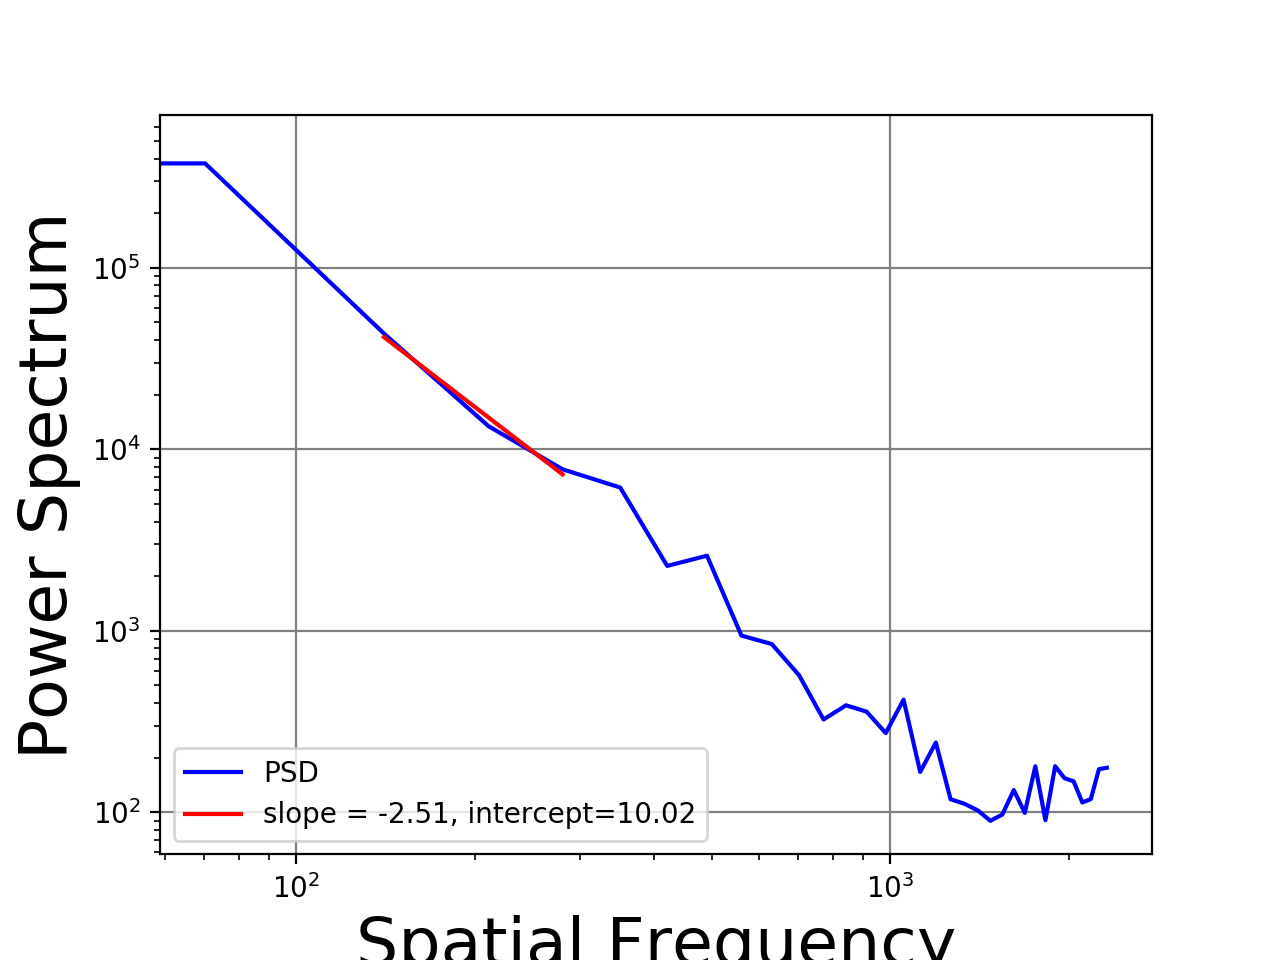

<IPython.core.display.Javascript object>


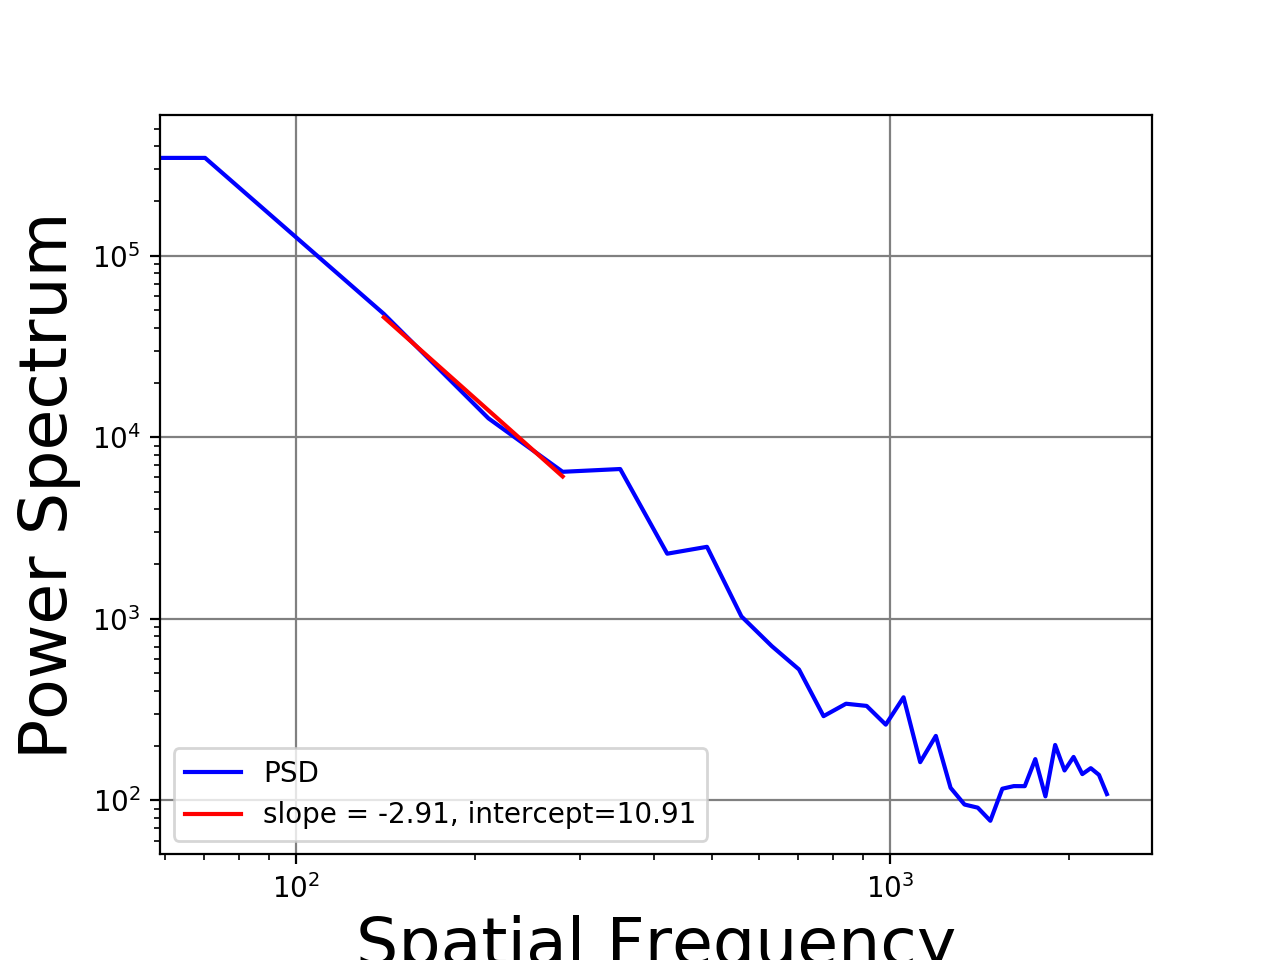

In [123]:
PSDplot(mean_psd1D)
PSDplot(psd1D[4])

# Radial profile 

In [33]:
def radialProfile(image, center=None):
    """
    Calculate the avearge radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    ## Calculate the indices from the image
    y,x = np.indices((image.shape)) # first determine radii of all pixels
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
     
    r = np.hypot(x - center[0], y - center[1]).astype(np.int) 
    
    ## how many per bin (i.e., histogram)
    tbin = np.bincount(r.ravel(), image.ravel())
    nr = np.bincount(r.ravel())

    ## average in each bin
    radialprofile = tbin / nr
    
    return radialprofile 
